# New metric
The aim of this notebook is to establish a new metric to quantify larvae curvature/morphology. Basically doing a PCA with curvature estimate, solidity, eccentricity and ferret diameter (excluded here as it is dependent on pixel size). I manually labelled a few larvae for different types o curvatures to see if they would cluster in groups

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import plotly.express as px
from plotdelice.graphs import violinplot_delice, barplot_delice, multiplot_delice, scatterplot_delice, markerplot_delice
import json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
def coordinates_to_svg_path(coordinates):
    path = "M {} {} ".format(*coordinates[0])  # Move to the first point
    for coordinate in coordinates[1:]:
        path += "L {} {} ".format(*coordinate)  # Draw a line to each subsequent point
    return path


In [177]:
df = pd.read_csv('/Volumes/G_MLS_RB_UHOME$/qfavey/01_Experiments/B_Muscle_inhibition/ALL_analysis/ALL_RESULTS_curvtypes.csv')
df.head()

,Unnamed: 0,eye size,head size,jaw size,heart size,yolk size,bladder size,tail length,spine length,body length,...,bent spine,dead,unhatched,eccentricity,ferretd,solidity,body angle,fish id,Curvtype,spine coords
0,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.92,NaN,...,True,True,False,0.955582,1231.920858,0.429414,NaN,Cc2d2a_1.png,A,[[ 922 2009]\n [ 922 2010]\n [ 923 2007]\n ......
1,32,0.300,NaN,NaN,0.107,1.38,NaN,0.631,5.71,6.21,...,True,False,False,0.987838,1443.835171,0.559748,176.994,Cc2d2a_10.png,A,NaN
2,33,0.240,0.378,NaN,NaN,1.72,0.154,0.324,4.01,5.55,...,True,False,False,0.949377,1285.651586,0.426307,175.690,Cc2d2a_11.png,C,NaN
3,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,NaN,NaN,NaN,NaN,Cc2d2a_12.png,C,[[ 984 1288]\n [ 984 1289]\n [ 984 1290]\n ......
4,35,0.261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,False,NaN,NaN,NaN,NaN,Cc2d2a_13.png,C,[[1022 1584]\n [1022 1585]\n [1022 1586]\n ......


In [4]:
with open('/Volumes/G_MLS_RB_UHOME$/qfavey/01_Experiments/B_Muscle_inhibition/ALL_analysis/ALL_RESULTS.json', 'r') as json_file:
   coords = json.load(json_file)

# for key, value in coords.items()[:2]:
#     if isinstance(value,list):
#         coords[key] = np.array(value)
#         #coords[key] = ' '.join(['%s%d %d' % (['M', 'L'][i>0], x, y) for i, (x, y) in enumerate(coords[key])])
#         coords[key] = coordinates_to_svg_path(coords[key])
#     else:
#         coords[key] = np.nan

In [266]:
for name in coords:
    df['spine coords'][df['fish id']==name] = coords[name]

/var/folders/f0/y364b8p96378s61mk8x86ksr0000gn/T/ipykernel_40568/3550008987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spine coords'][df['fish id']==name] = coords[name]
/var/folders/f0/y364b8p96378s61mk8x86ksr0000gn/T/ipykernel_40568/3550008987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spine coords'][df['fish id']==name] = coords[name]
/var/folders/f0/y364b8p96378s61mk8x86ksr0000gn/T/ipykernel_40568/3550008987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [267]:
groups = []
for name in df['fish id']:
    if 'cc2d2a' in name.lower():
        groups.append('cc2d2a')
    if 'WT' in name:
        groups.append('WT')
    if 'inpp5e' in name.lower():
        groups.append('inpp5e')
df['condition'] = groups

In [268]:
df['body curvature'][(df['body curvature']>4) & (df['condition']=='WT')] = np.nan
df = df[(df['Curvtype']!='ctrl') & (df['Curvtype']!='LR')] 
df = df.dropna(subset=['body curvature','solidity','eccentricity','condition','fish id','Curvtype','spine coords'])

/var/folders/f0/y364b8p96378s61mk8x86ksr0000gn/T/ipykernel_40568/471874768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['body curvature'][(df['body curvature']>4) & (df['condition']=='WT')] = np.nan


In [269]:
for cond in np.unique(df['condition']):
    print('#',cond,":",len(df[df['condition'] == cond]))

# cc2d2a : 92
# inpp5e : 16


In [270]:
from svgpath2mpl import parse_path
df['spine coords'] = df['spine coords'].apply(parse_path)

In [271]:
df = df.sort_values(by='Curvtype')

## K-means clustering

In [272]:
df = df.dropna(subset=['body curvature','solidity','Curvtype','eccentricity'])
features, true_label_names = np.array(list(zip(df['solidity'],df['eccentricity']))),df['Curvtype']


In [273]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [274]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)
df['encoded labels'] = true_labels
n_clusters = len(label_encoder.classes_)

In [275]:
print(true_labels,true_label_names)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3] 0      A
129    A
133    A
135    A
137    A
      ..
41     T
9      T
76     T
31     T
82     T
Name: Curvtype, Length: 108, dtype: object


clustering with k-means

In [276]:
# Define the range of clusters to try
range_n_clusters = list(range(2, 11))

# List to store silhouette scores for different cluster counts
silhouette_scores = []

# Loop over the range of cluster numbers
for n_clusters in range_n_clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=10, max_iter=500, random_state=42)
    
    # Fit the KMeans model
    kmeans.fit(scaled_features)
    
    # Predict the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate the silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)
    
    # Print the silhouette score for the current number of clusters
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.4f}")

# Find the number of clusters with the highest silhouette score
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nThe optimal number of clusters is {optimal_n_clusters} with a silhouette score of {max(silhouette_scores):.4f}")

kmeans = KMeans(init="random", n_clusters=optimal_n_clusters, n_init=10, max_iter=500, random_state=42)

# Fit the KMeans model
kmeans.fit(scaled_features)

# Predict the cluster labels
cluster_labels = kmeans.labels_


For n_clusters = 2, the average silhouette score is 0.4653
For n_clusters = 3, the average silhouette score is 0.5264
For n_clusters = 4, the average silhouette score is 0.4812
For n_clusters = 5, the average silhouette score is 0.5042
For n_clusters = 6, the average silhouette score is 0.5133
For n_clusters = 7, the average silhouette score is 0.4644
For n_clusters = 8, the average silhouette score is 0.4180
For n_clusters = 9, the average silhouette score is 0.3966
For n_clusters = 10, the average silhouette score is 0.4379

The optimal number of clusters is 3 with a silhouette score of 0.5264


In [277]:
df['kmeans'] = kmeans.labels_


R^2:  0.8955199451993807


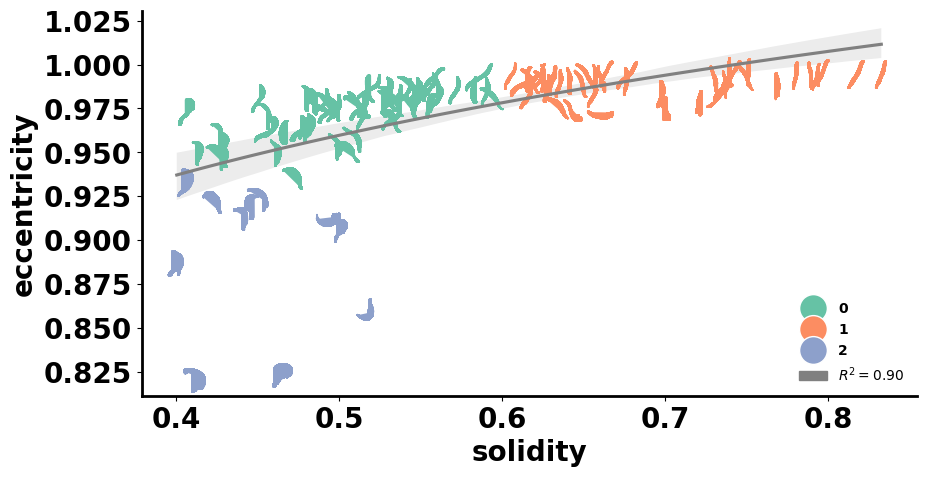

In [278]:
from scipy.spatial import Voronoi, voronoi_plot_2d

centers = kmeans.cluster_centers_
fig, axs = markerplot_delice(df,"solidity","eccentricity","kmeans","spine coords",add_regression='logx',palette='Set2',figsize=(10,5))
# plt.scatter(centers[:,0],centers[:,1], marker='s', s=100,color='red')


# extended_centers = add_bounding_points(centers)
# vor = Voronoi(extended_centers)

# voronoi_plot_2d(vor,axs,show_vertices=False, line_colors='orange',
#                      line_width=2, line_alpha=0.6, point_size=2)

plt.show()


R^2:  0.7009406196644741


(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='eccentricity', ylabel='body curvature'>)

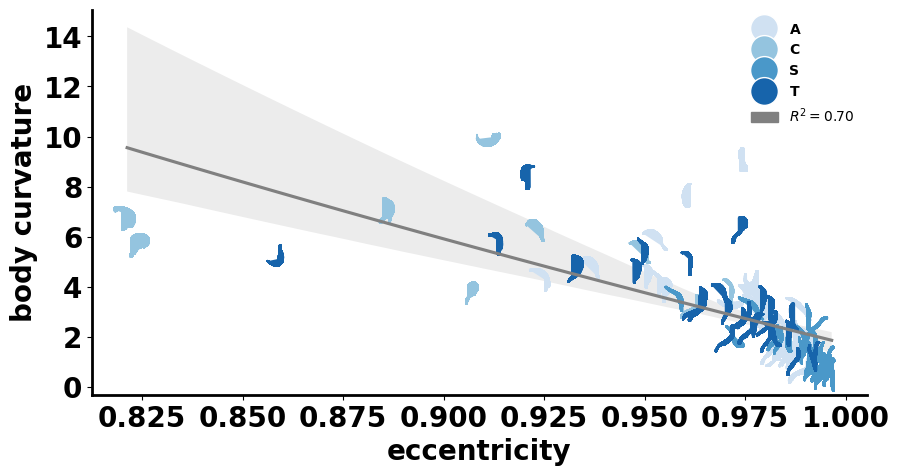

In [279]:
markerplot_delice(df,"eccentricity","body curvature","Curvtype","spine coords", add_regression='logx',figsize=(10,5))

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

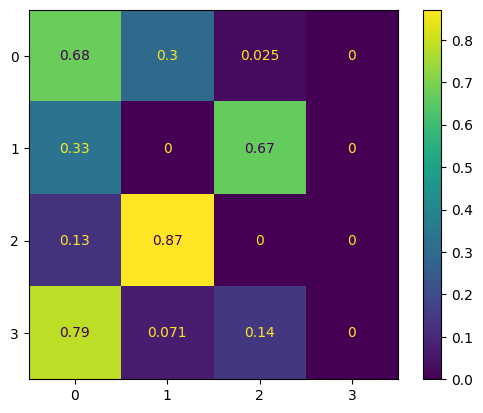

In [280]:
# Compute the confusion matrix
cm = confusion_matrix(df['encoded labels'], df['kmeans'],normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_encoder.inverse_transform(df['kmeans'])))
disp.plot()
plt.show()
print('accuracy: ', accuracy_score(df['encoded labels'],df['kmeans']))

## Pipeline

In [281]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)
n_clusters = len(label_encoder.classes_)


In [282]:
preprocessor = Pipeline([("scaler",StandardScaler()),("pca",PCA(n_components=2,random_state=4))])
clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n_clusters,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=42,
               ),
           ),
       ]
    )
pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

In [283]:
features, true_label_names, id = np.array(list(zip(df['solidity'],df['body curvature'],df['eccentricity']))),true_labels, df['fish id']
pipe.fit(features)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=4))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=4, n_init=50,
                                         random_state=42))]))])

In [284]:
preprocessed_data = pipe["preprocessor"].transform(features)
predicted_labels2 = label_encoder.inverse_transform(pipe["clusterer"]["kmeans"].labels_)
silhouette_score(preprocessed_data, predicted_labels2)
#print(preprocessed_data.explained_variance_ratio)

0.4980024103472716

In [285]:
pcadf = pd.DataFrame(
     pipe["preprocessor"].transform(features),
     columns=["PC 1", "PC 2"],
 )

pcadf["predicted_cluster"] = label_encoder.inverse_transform(pipe["clusterer"]["kmeans"].labels_)
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)


In [286]:
df['Curvtype'][df['spine coords'] == 'nan']
pcadf['spine coords'] = df['spine coords']
pcadf = pcadf.dropna()


(<Figure size 1500x1000 with 1 Axes>, <Axes: xlabel='PC 1', ylabel='PC 2'>)

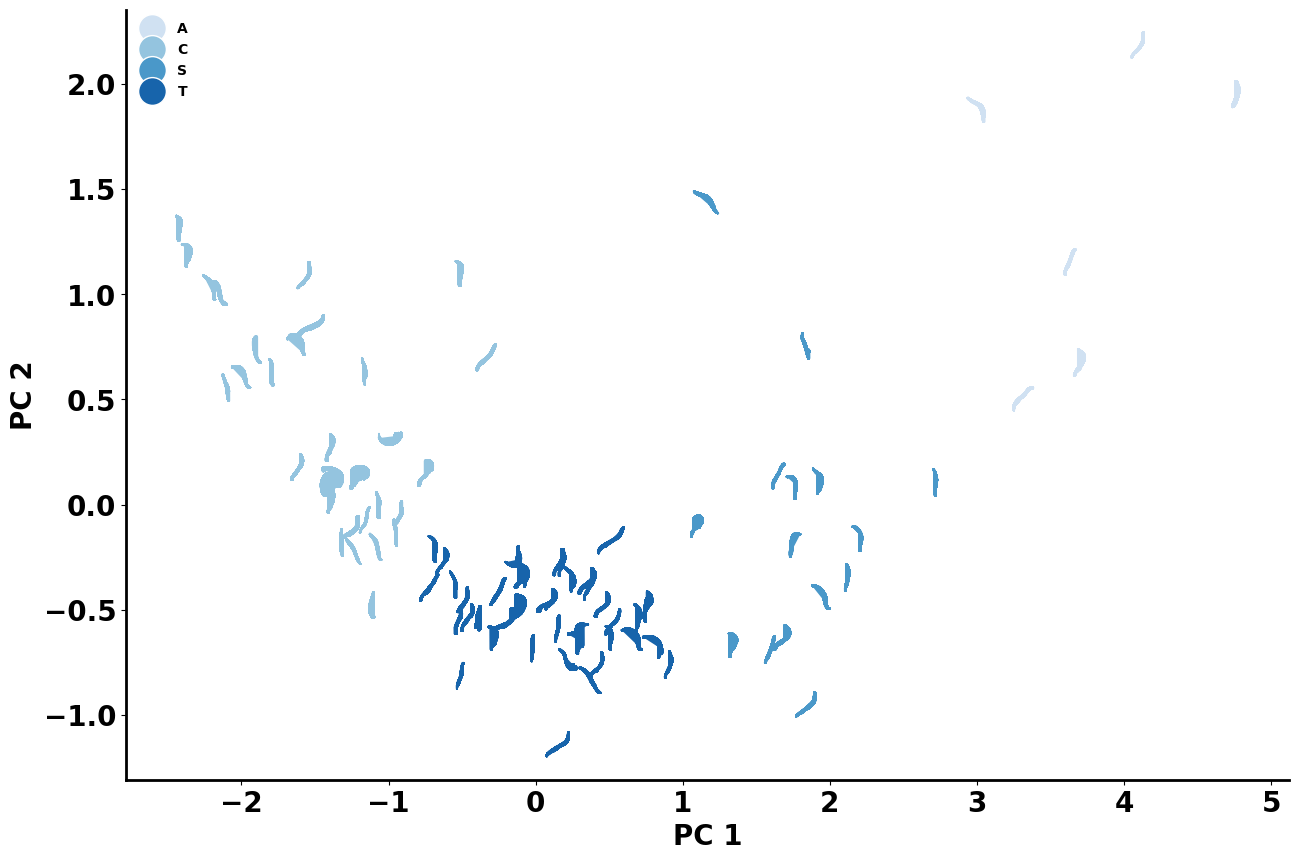

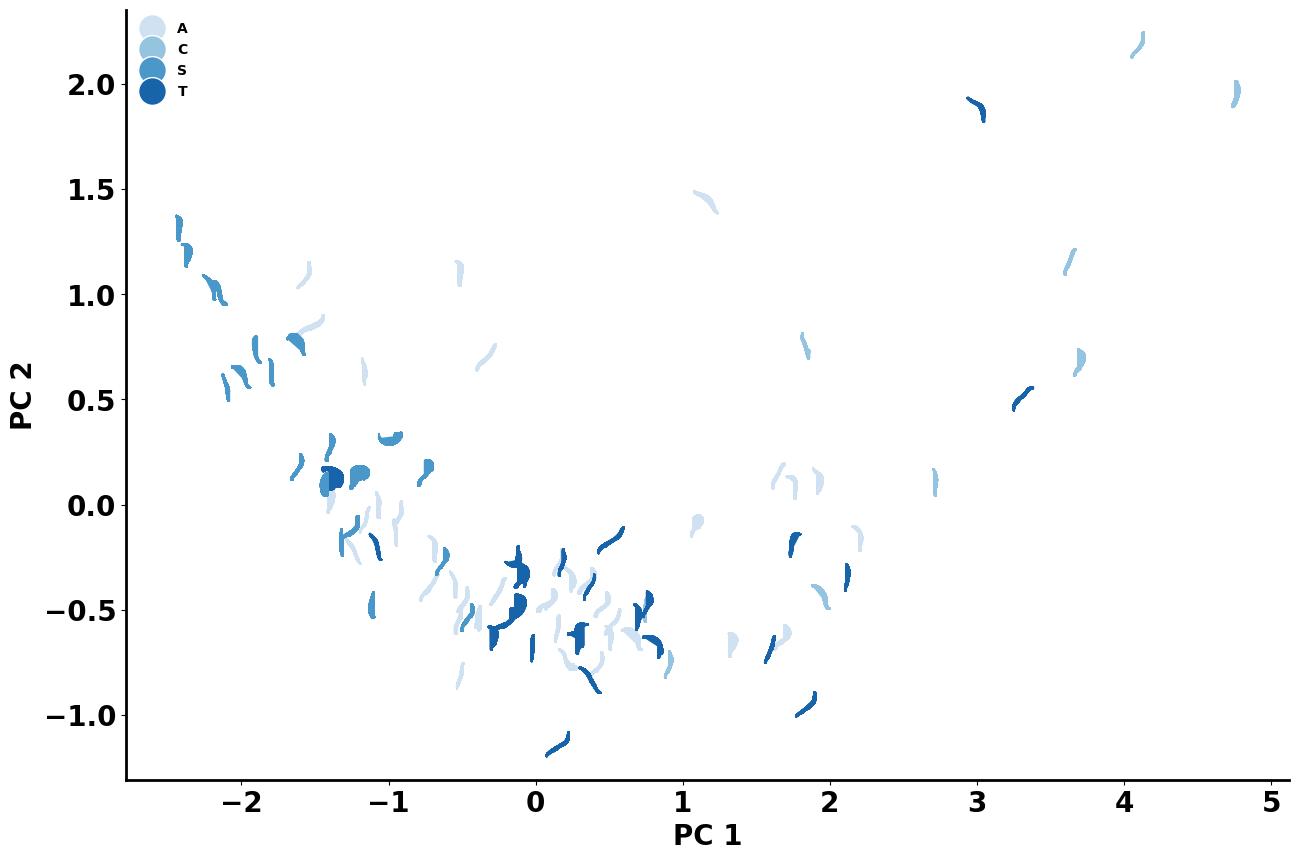

In [287]:
pcadf = pcadf.dropna()
markerplot_delice(pcadf,"PC 1","PC 2","predicted_cluster","spine coords")
markerplot_delice(pcadf,"PC 1","PC 2","true_label","spine coords")

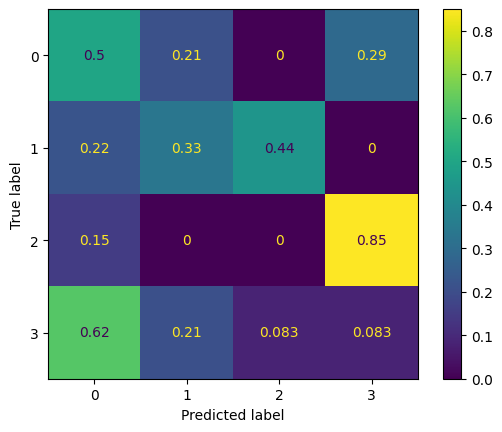

accuracy:  0.26373626373626374


In [243]:
# Compute the confusion matrix
#true_labels = label_encoder.inverse_transform(true_labels)
cm2 = confusion_matrix(pcadf['true_label'], pcadf['predicted_cluster'],normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=np.unique(pcadf["true_label"]))
disp.plot()
plt.show()
print('accuracy: ', accuracy_score(pcadf['true_label'], pcadf['predicted_cluster']))